### Scanpy Integration
Trying to integrate [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) into scRNA-seq processing workflow.  
Testing out simple read-write, dimension reduction, and visualization with basic Scanpy tools.

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *
import scanpy as sc

In [2]:
retina = sc.read('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz')

Only considering the two last: ['.tsv', '.gz'].
Only considering the two last: ['.tsv', '.gz'].


In [3]:
retina.shape

(1326, 20478)

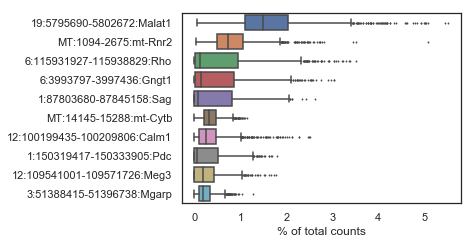

In [4]:
sc.pl.highest_expr_genes(retina, n_top=10)

In [5]:
# get total counts for each observation (cell)
retina.obs['n_counts'] = retina.X.sum(axis=1) 

# get total number of genes detected for each observation (cell)
retina.obs['n_genes'] = retina.X.astype(bool).sum(axis=1)

# quick reordering of AnnData object, since our analysis assumes libraries sorted from highest to lowest quality
reorder_AnnData(retina)

# create new "observations" of percent mito reads per cell
mito_genes = retina.var_names.str.contains(':mt-') 
retina.obs['percent_mito'] = np.sum(retina[:, mito_genes].X, axis=1) / retina.obs['n_counts']

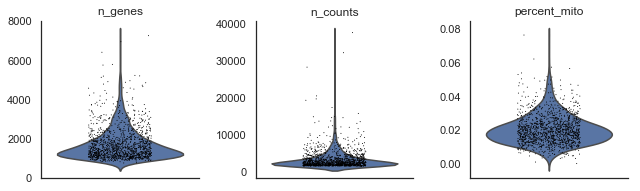

In [6]:
sc.pl.violin(retina, ['n_genes','n_counts','percent_mito'], jitter=0.2, multi_panel=True)

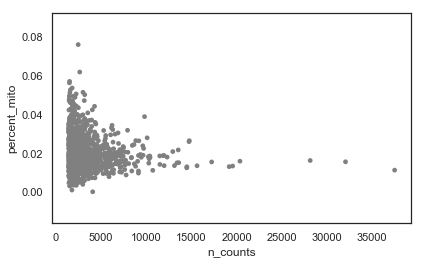

In [7]:
sc.pl.scatter(retina, x='n_counts', y='percent_mito')

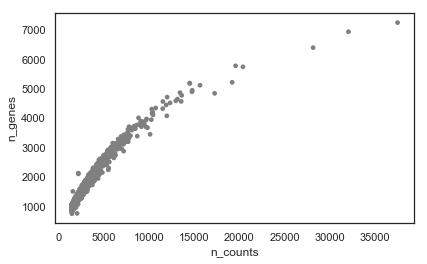

In [8]:
sc.pl.scatter(retina, x='n_counts', y='n_genes')

In [9]:
retina.var['n_counts'] = retina.X.sum(axis=0)
retina.var['n_cells'] = retina.X.astype(bool).sum(axis=0)

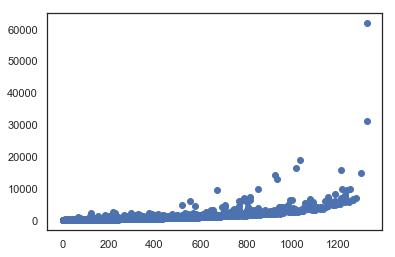

In [10]:
plt.scatter(data=retina.var, x='n_cells', y='n_counts')

In [11]:
retina.raw = retina # checkpoint save raw data

In [12]:
retina.raw.X

array([[0., 3., 1., ..., 0., 0., 0.],
       [0., 0., 3., ..., 5., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 2., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]], dtype=float32)

In [13]:
def gf_icf(adata):
    '''return GF-ICF scores for each element in anndata counts matrix'''
    tf = adata.X.T / adata.X.sum(axis=1)
    tf = tf.T
    
    ni = adata.X.astype(bool).sum(axis=0)
    idf = np.log(adata.n_obs / (ni+1))
    
    return tf*idf

In [14]:
retina_gficf = gf_icf(retina)

In [16]:
retina.var['gf-icf'] = retina_gficf.sum(axis=0)

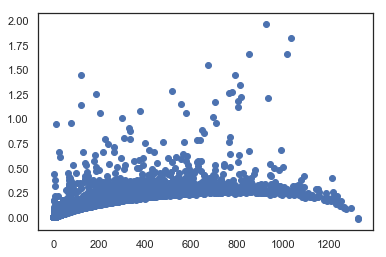

In [17]:
plt.scatter(data=retina.var, x='n_cells', y='gf-icf')

In [55]:
# total-count normalize (lib size correct) to 10k reads per cell
sc.pp.normalize_per_cell(retina, counts_per_cell_after=10000)
sc.pp.log1p(retina) # log-transform counts

In [56]:
sc.pp.highly_variable_genes(retina, min_mean=0.0125, max_mean=3, min_disp=0.5)

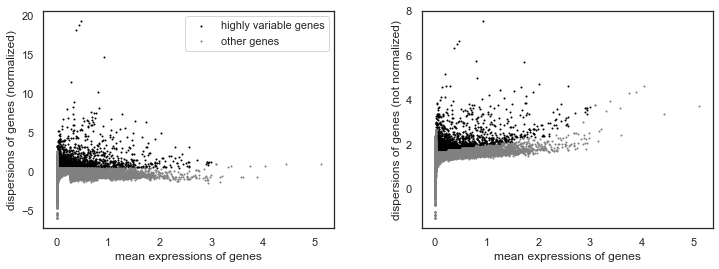

In [57]:
sc.pl.highly_variable_genes(retina)

In [59]:
retina.var.sort_values('gf-icf', ascending=False)

,n_counts,n_cells,gf-icf,highly_variable,means,dispersions,dispersions_norm
1:87803680-87845158:Sag,14194.0,927,1.966814,False,3.750936e+00,4.290547,0.707107
6:115931927-115938829:Rho,18958.0,1035,1.829528,False,4.041384e+00,4.617975,0.707105
6:3993797-3997436:Gngt1,16550.0,1018,1.667564,False,3.886796e+00,4.361948,-0.707108
1:150319417-150333905:Pdc,9849.0,850,1.664475,False,3.377684e+00,3.953421,0.707107
2:158375638-158386145:Snhg11,9584.0,672,1.553850,True,2.905761e+00,3.648995,1.263092
13:99898484-99900683:Cartpt,2319.0,122,1.450738,True,1.723000e+00,5.719560,6.309385
14:52110704-52163546:Rpgrip1,7183.0,790,1.444295,False,3.094819e+00,3.783613,1.029836
11:120447605-120453500:Pde6g,7346.0,815,1.347264,False,3.087732e+00,3.766819,1.005426
16:96467606-96525793:Pcp4,4751.0,518,1.288212,True,2.429831e+00,3.820997,2.314443
1:4343507-4360314:Rp1,6197.0,776,1.280472,True,2.947975e+00,3.631572,1.238107


In [60]:
# filter for HVGs
retina = retina[:, retina.var['highly_variable']]

In [67]:
retina.n_vars

2986

In [61]:
sc.tl.pca(retina)

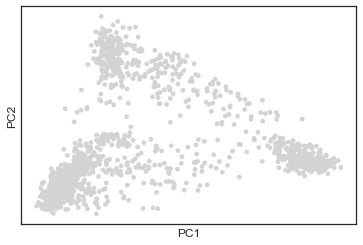

In [62]:
sc.pl.pca(retina)

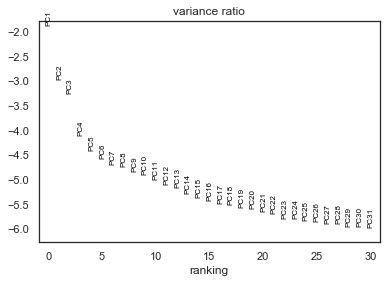

In [63]:
sc.pl.pca_variance_ratio(retina, log=True)

In [64]:
retina

AnnData object with n_obs × n_vars = 1326 × 2986 
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_counts', 'n_cells', 'gf-icf', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [65]:
sc.pp.neighbors(retina, n_neighbors=30, n_pcs=30)

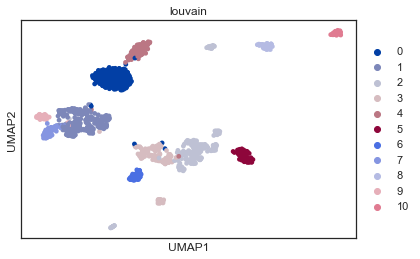

In [66]:
sc.tl.louvain(retina)
sc.tl.umap(retina)
sc.pl.umap(retina, color=['louvain'])

---
### Process with GF-ICF feature selection

In [70]:
retina2 = sc.AnnData(X=retina.raw.X, obs=retina.obs)

In [71]:
retina2.var['n_counts'] = retina2.X.sum(axis=0)
retina2.var['n_cells'] = retina2.X.astype(bool).sum(axis=0)

In [72]:
retina2.var['gf-icf'] = retina_gficf.sum(axis=0)

In [74]:
retina2.X = retina_gficf

In [75]:
# total-count normalize (lib size correct) to 10k reads per cell
sc.pp.normalize_per_cell(retina2, counts_per_cell_after=10000)

In [79]:
retina2.var.sort_values('gf-icf', ascending=False).iloc[0:3000,].index

Index(['9574', '15030', '15526', '8703', '10316', '4160', '4524', '1381',
       '6262', '9236',
       ...
       '683', '9201', '10160', '606', '12839', '7167', '17176', '2078',
       '10040', '6746'],
      dtype='object', length=3000)

In [80]:
# filter for top 3k gf-icf genes
retina2 = retina2[:, retina2.var.sort_values('gf-icf', ascending=False).iloc[0:3000,].index]

In [81]:
retina2.n_vars

3000

In [82]:
sc.tl.pca(retina2)

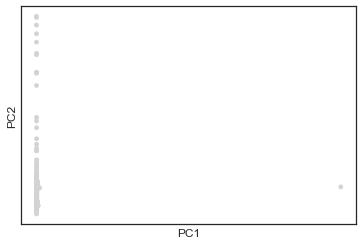

In [83]:
sc.pl.pca(retina2)

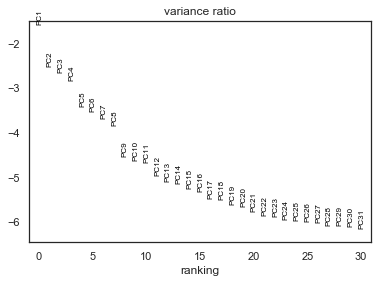

In [84]:
sc.pl.pca_variance_ratio(retina2, log=True)

In [85]:
retina2

AnnData object with n_obs × n_vars = 1321 × 3000 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'louvain'
    var: 'n_counts', 'n_cells', 'gf-icf'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [86]:
sc.pp.neighbors(retina2, n_neighbors=30, n_pcs=30)

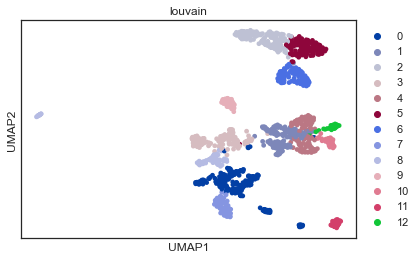

In [87]:
sc.tl.louvain(retina2)
sc.tl.umap(retina2)
sc.pl.umap(retina2, color=['louvain'])

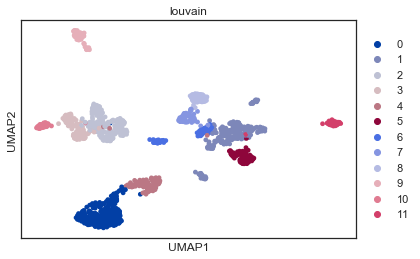

In [22]:
sc.tl.louvain(retina)
sc.tl.umap(retina)
sc.pl.umap(retina, color=['louvain'])